## Интерполяция изображений, геометрия формирования изображения и калибровка камеры

In [1]:
import cv2
import skimage
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

1. Интерполяция изображений.

![](https://upload.wikimedia.org/wikipedia/commons/9/90/Comparison_of_1D_and_2D_interpolation.svg)
Задача - эффективно уменьшить/увеличить изображение.

Рассмотрим несколько методов интерполяции.

а) Интерполяция по ближайшему пикселю

![](https://habrastorage.org/r/w1560/webt/vv/hk/4r/vvhk4reoaqggmf25vviiqmaoyik.png)

Самая простая и самая быстрая, однако она приводит к сильным артефактам.

б) Билинейная интерполяция

![](https://habrastorage.org/r/w1560/webt/h2/ab/we/h2abwehy35ue34opji-gwlgisoe.png)

Лучше по качеству, но требует больше вычислений и вдобавок размывает границы объектов.

в) Бикубическая интерполяция

![](https://habrastorage.org/r/w1560/webt/h2/ab/we/h2abwehy35ue34opji-gwlgisoe.png)

Еще лучше в непрерывных областях, но на границе возникает [эффект гало](https://ru.wikipedia.org/wiki/Гало) (более темная полоса вдоль темного края границы и светлая вдоль светлого). Чтобы избежать такого эффекта нужно использовать неотрицательное ядро свертки например кубический b-сплайн.

Согласно учебнику [OpenCV](https://docs.opencv.org/3.4/da/d6e/tutorial_py_geometric_transformations.html) для **сжатия изображения** — наиболее предпочтительным методом интерполяции является cv.INTER_AREA,
**для увеличения изображения** — наиболее предпочтительны методы интерполяции: cv.INTER_CUBIC (медленный) и cv.INTER_LINEAR.



orig size: h=172, w=448, resised size: h=860, w=2240


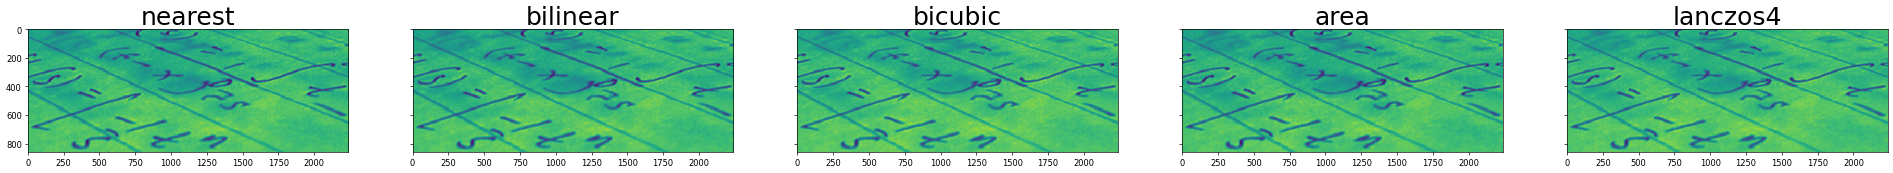

In [2]:
from skimage import data

interpolation_algorithm = [ 
    ("nearest", cv2.INTER_NEAREST), 
    ("bilinear", cv2.INTER_LINEAR), 
    ("bicubic", cv2.INTER_CUBIC), 
    ("area", cv2.INTER_AREA),
    ("lanczos4", cv2.INTER_LANCZOS4)
]

def resize_by_factor(
    img: np.array,
    factor: float,
) -> None:

    height, width = img.shape[:2]
    height2, width2 = int(height*factor), int(width*factor)

    print(f'orig size: h={height}, w={width}, resised size: h={height2}, w={width2}') 

    fig, axes = plt.subplots(
        ncols=len(interpolation_algorithm),
        sharex=True,
        sharey=True,
        figsize=(40, 10),
        dpi=60,
    )

    imgs = []
    for i in range(len(interpolation_algorithm)):

        img_resized = cv2.resize(
            src=img,
            dsize=(width2, height2),
            interpolation=interpolation_algorithm[i][1],
        )

        axes[i].imshow(img_resized)
        axes[i].set_title(
            interpolation_algorithm[i][0],
            fontsize=30,
        )

resize_by_factor(
    img=data.text(),
    factor=5,
)

orig size: h=172, w=448, resised size: h=34, w=89


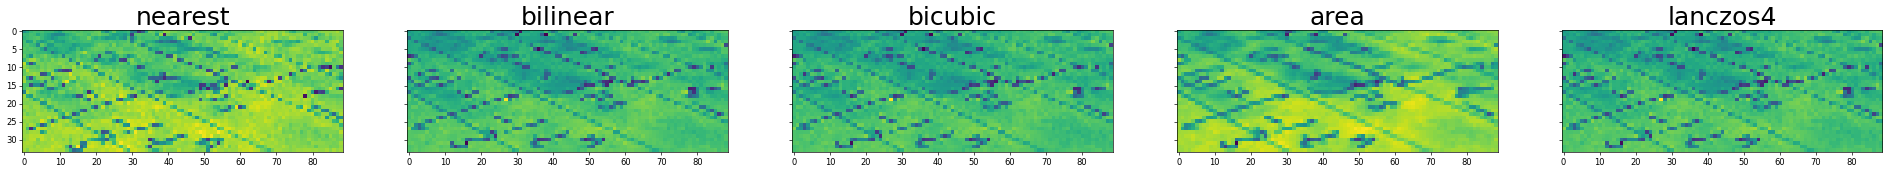

In [3]:
resize_by_factor(
    img=data.text(),
    factor=0.2,
)

Вопрос 1. Можно ли реализовать сжатие изображений на свертках? Как подбирать параметры ядра? Приведите примеры + код


Концептуально, чтобы сжать изображение, мы сначала должны пройтись низкочастотным фильтром во избежания алиасинга (эффект, когда сигналы неразличимы), а потом сохранить каждый $r$-ый сэмпл.

На практике мы просто применяем свертку к каждому $r$-ому сэмплу, т.е.
$g(i, j) = \sum_{k,l} f(k, l) * h(ri − k, rj − l) = \frac{1}{r} \sum_{k,l} f(k, l) * h(i − \frac{k}{r}, j − \frac{1}{r}) $

В зависимости от типа интерполяции подбирается ядро. 
К примеру, ниже на изображении представлена функция для Nearest Neigbour.

![](https://zipcpu.com/img/interpolation-fig-nnbor.png)

В Nearest Neigbour по факту свертка не нужна, так как для сжатия нам достаточно выбрать каждый n-ый сэмпл, если мы хотим сжать в n раз.

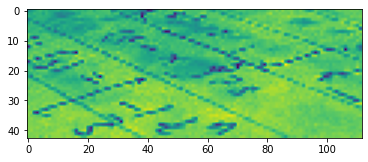

In [4]:
img = data.text()
h, w  = img.shape
kernel_size = 4
kernel = np.zeros((kernel_size, kernel_size))
kernel[kernel_size // 2, kernel_size // 2] = 1

my_img_resized = img[::kernel_size, ::kernel_size]
cv_img_resized = cv2.resize(src=img, dsize=(w // 4, h // 4), interpolation=cv2.INTER_NEAREST)

assert((my_img_resized == cv_img_resized).all())

plt.imshow(my_img_resized)
plt.show()

При билинейной интерполяции мы должны учитывать 4 пикселя по бокам, после чего брать их weighted average. \\
Для `kernel_size = 2` матрица будет выглядеть так: 
```
matrix = 1/4 * [
    [1, 1],
    [1, 1]
]
```
Для `kernel_size = 3` матрица будет выглядеть так: 
```
matrix = 1/8 * [
    [0, 1, 0],
    [1, 4, 1],
    [0, 1, 0]
]
```
Смысл в том, чтобы учитывать по обеим осям x и y соседние координаты, после чего с их помощью делать интерполяцию.

## Трансформация изображений

Реализуется с помощью матриц 3x3

1. Поворот (Rotation)
Входные параметры: угол поворота (angle)
```python
matrix = np.array([
      [np.cos(angle),  np.sin(angle), 0],
      [-np.sin(angle), np.cos(angle), 0],
      [0,              0,             1],
])
```
2. Растяжение/сжатие (Scale)
Входные параметры: фактор растяжения (tx, ty)
```python
matrix = np.array([
      [t[0], 0,    0],
      [0,    t[1], 0],
      [0,    0,    1],
])
```

3. Перенос (translation)
Входные параметры: фактор переноса (tx, ty)
```python
matrix = np.array([
      [1,  0, t[0]],
      [0,  1, t[1]],
      [0,  0,    1],
])
```

4. Сдвиг (shearing)
Входные параметры: фактор сдвига (tx, ty)
```python
matrix_horisontal = np.array([
      [1,    t[0], 0],
      [t[1], 1,    0],
      [0,    0,    1],
])
```


Вопрос 1. Реализуйте функцию, которая принимает изображение и матрицу преобразования, и реализует афинную трансформацию. Не забудьте про центрирование.

 Идея - афинное перемещение пикселей изображения.

In [5]:
def affine_transform(
    img: np.array,
    mat: np.array,
) -> np.array:

    # T(x) = A(x − c) + t + c
    
    H, W, _ = img.shape
    cx, cy = (H + 1) // 2 - 1, (W + 1) // 2 - 1

    offset_M = make_translation([cx, cy]) @ mat
    transformed_img = np.zeros_like(img)

    transformed_idx = []

    for x in range(H):
        for y in range(W):
            warp_coords = offset_M @ np.array([x - cx, y - cy, 1])
            transformed_idx.append(warp_coords[:2])

    transformed_idx = np.array(transformed_idx)
    transformed_img = cv2.remap(
        img, 
        transformed_idx[:, 0].astype('float32').reshape(W, H), 
        transformed_idx[:, 1].astype('float32').reshape(W, H), 
        cv2.INTER_CUBIC
    )
    
    return transformed_img.transpose(1, 0, 2)


def make_rotation(params):
    angle = params[0]
    mat = np.array([
      [np.cos(angle),  np.sin(angle), 0],
      [-np.sin(angle), np.cos(angle), 0],
      [0,              0,             1],
    ])

    return mat

def make_scaling(params):
    tx, ty = params[0], params[1]
    mat = np.array([
      [tx, 0,  0],
      [0,  ty, 0],
      [0,  0,  1],
    ])

    return mat

def make_translation(params):
    tx, ty = params[0], params[1]
    mat = np.array([
      [1,  0, tx],
      [0,  1, ty],
      [0,  0, 1],
    ])

    return mat

def make_shearing(params):
    tx, ty = params[0], params[1]
    mat = np.array([
      [1,  tx, 0],
      [ty, 1,  0],
      [0,  0,  1],
    ])

    return mat

Проверьте код на примере изображения c астронавтом

In [6]:
import ipywidgets
from skimage import data

img = data.astronaut()

#resize image for much faster affine processing
img = cv2.resize(
    src=img,
    dsize = None,
    fx=0.3,
    fy=0.3,
    interpolation=cv2.INTER_AREA,
)

@ipywidgets.interact(
    tx=ipywidgets.FloatSlider(
        min=-3.14, max=3.14,
        step=0.01, value=1.,
    ),

    ty=ipywidgets.FloatSlider(
        min=-3.14, max=3.14,
        step=0.01, value=1.,
    ),
)
def play_with_params(
    tx: float,
    ty: float,
) -> None:

    # an example
    mat = make_shearing(
        (tx, ty),
    )

    transformed_img = affine_transform(
        img=img,
        mat=mat
    )

    plt.imshow(transformed_img)

interactive(children=(FloatSlider(value=1.0, description='tx', max=3.14, min=-3.14, step=0.01), FloatSlider(va…

Вопрос 2. Запустите все 4 преобразования. Изменяйте параметры алгоритма. Имеются ли пиксели, которые никуда не перешли в результате трансформации? Что с ними можно сделать?

Да, есть пиксели, которые никуда не перешли в результате трансформации. Для этого используем в алгоритме интерполяцию, чтобы приблизительно заполнить те символы. Также можно добавить паддинг по бокам, чтобы изображение поместилось полностью.

### Формирование изображения

**Внешние параметры камеры**

Некоторые камеры-обскуры вносят значительные искажения в изображения. Два основных вида искажений - это радиальные искажения и тангенциальные искажения.

 **Радиальные искажение** возникает из-за неидеальности линз и приводит к тому, что прямые линии кажутся изогнутыми.
**Тангенциальное искажение** возникает из-за того, что объектив для съемки изображения не выровнен идеально параллельно плоскости изображения. Таким образом, некоторые области на изображении могут выглядеть ближе, чем ожидалось. 

Виды радиального искажения:
<figure>
<img src="https://upload.wikimedia.org/wikipedia/commons/6/63/Barrel_distortion.svg" alt="drawing" width="200"/>
<figcaption>Barrel distortion (Positive k1 > 0)</figcaption>
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5b/Pincushion_distortion.svg" alt="drawing" width="200"/>
<figcaption>Pincushion distortion (Negative k1 < 0)</figcaption>
<img src="https://upload.wikimedia.org/wikipedia/commons/3/3c/Mustache_distortion.svg" alt="drawing" width="200"/>
<figcaption>Mustache distortion (Complex)</figcaption>
</figure>

Формулы:

$x_{dist} = x\frac{1+k_{1}r^{2}+k_{2}r^{4} + k_{3}r^{6}}{1+k_{4}r^{2}+k_{5}r^{4} + k_{6}r^{6}} + 2p_{1}xy + p_{2}(r^{2} + 2x^{2})$

$y_{dist} = y\frac{1+k_{1}r^{2}+k_{2}r^{4} + k_{3}r^{6}}{1+k_{4}r^{2}+k_{5}r^{4} + k_{6}r^{6}} + p_{1}(r^{2} + 2y^{2}) + 2p_{2}xy$,

где $r^{2} = x^{2} + y^{2}$

Таким образом, параметры радиальной дисторсии - ($k_{1}, \cdots, k_{6}$), тангенциальной дисторсии - ($p_{1}, p_{2}$)

В дополнение к этому нам нужны внутренние и внешние параметры камеры. Внутренние параметры специфичны для конкретной камеры. Они включают в себя такую информацию, как фокусное расстояние (fx,fy) и оптические центры (cx, cy). Фокусное расстояние и оптические центры могут быть использованы для создания матрицы камеры, которую можно использовать для устранения искажений, вызванных объективами конкретной камеры. Матрица камеры уникальна для конкретной камеры, поэтому после расчета ее можно повторно использовать на других изображениях, сделанных той же камерой.

Вопрос 3. Запишите выражение связи точек в координатной системе камеры (x, y, z) c проекцией (изображением), зная параметры дисторсии и параметры камеры.

$
\begin{bmatrix} u \\ w \\ 1 \end{bmatrix} = K * distort(\begin{bmatrix} \frac{x}{z} \\ \frac{y}{z} \\ 1 \end{bmatrix} )
$, \\
где intrinsic matrix $K = \begin{bmatrix} f_x & \gamma & c_x \\ 0 & f_y & c_y \\  0 & 0 & 1 \end{bmatrix}$

Вопрос 4. Найдите параметры вашей камеры мобильного телефона. Используйте шаблон шахматной [доски](https://www.oreilly.com/library/view/learning-opencv-3/9781491937983/assets/lcv3_ac01.png)(его нужно распечатать), и воспользоваться туториалами, например [англ](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html), [рус](https://waksoft.susu.ru/2020/02/29/kalibrovka-kamery-s-ispolzovaniem-s-opencv/)

![](http://waksoft.susu.ru/wp-content/uploads/2020/02/calibration-patterns1.gif)
![](https://waksoft.susu.ru/wp-content/uploads/2020/02/checkerboard-pattern-detection21.jpg)

In [ ]:
! unzip images.zip

In [8]:
import glob

# Узлы доски
CHECKERBOARD = (6, 9)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 300, 0.001)
# Создание вектора для хранения векторов трехмерных точек для каждого изображения шахматной доски
objpoints = []
# Создание вектора для хранения векторов 2D точек для каждого изображения шахматной доски
imgpoints = [] 
# Определение мировых координат для 3D точек
objp = np.zeros(
    shape=(1, CHECKERBOARD[0] * CHECKERBOARD[1], 3),
    dtype=np.float32,
)
objp[0, :, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
prev_img_shape = None
# Извлечение пути отдельного изображения, хранящегося в данном каталоге
images = glob.glob('./images/*.png')
i = 0
for fname in images:

    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Найти углы шахматной доски
    # Если на изображении найдено нужное количество углов, тогда ret = true
    ret, corners = cv2.findChessboardCorners(
        gray,
        CHECKERBOARD,
        cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE,
    )
    
    #Если желаемый номер угла обнаружен,
    #уточняем координаты пикселей и отображаем
    #их на изображениях шахматной доски

    if ret == True:
        print(fname)
        objpoints.append(objp)
        # уточнение координат пикселей для заданных 2d точек.
        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        
        imgpoints.append(corners2)
        
h,w = img.shape[:2]
"""
Выполнение калибровки камеры с помощью
Передача значения известных трехмерных точек (объектов)
и соответствующие пиксельные координаты
обнаруженные углы (imgpoints)
"""
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print("Camera matrix : \n")
print(mtx)
print("dist : \n")
print(dist)
print("rvecs : \n")
print(rvecs)
print("tvecs : \n")
print(tvecs)

./images/7.png
./images/6.png
./images/11.png
./images/4.png
./images/10.png
./images/12.png
./images/9.png
./images/2.png
./images/5.png
./images/3.png
./images/1.png
./images/8.png
Camera matrix : 

[[3.27889276e+03 0.00000000e+00 2.01204696e+03]
 [0.00000000e+00 3.26812890e+03 1.51012897e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist : 

[[ 2.49073633e-01 -1.38789392e+00 -1.66569954e-03 -5.35828483e-05
   2.38249235e+00]]
rvecs : 

[array([[-0.43774416],
       [-0.29867534],
       [-1.576324  ]]), array([[-0.09638767],
       [ 0.12040698],
       [-1.3359379 ]]), array([[-0.3848228 ],
       [-0.0260699 ],
       [-1.46241801]]), array([[-0.37720433],
       [-0.46144443],
       [-1.53712906]]), array([[ 0.03437856],
       [-0.42358301],
       [-1.33691142]]), array([[ 0.2228567 ],
       [ 0.13092758],
       [-1.5297843 ]]), array([[-0.58810676],
       [-0.62294869],
       [-1.52290919]]), array([[ 0.2919261 ],
       [-0.46490947],
       [-1.51153996]]), arra

In [9]:
img = cv2.imread('./images/10.png')
h,  w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

In [10]:
# undistort
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]

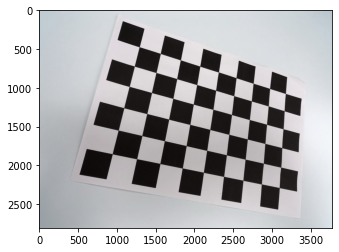

In [11]:
# after
plt.imshow(dst)

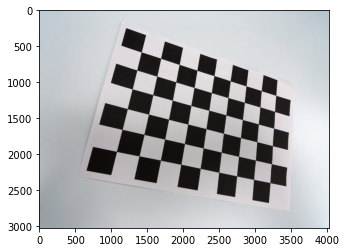

In [12]:
# before
plt.imshow(img)

## Метрика - ошибка репроектирования

In [13]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "total error: {}".format(mean_error/len(objpoints)) )

total error: 0.18251120468262316


Вопрос 5. Проанализуйте полученные параметры. Напишите краткий отчет о проделанной работе. Сравните реальное расстояние от объекта с полученным с помощью матриц калибровки.

- присутствует barrel дисторсия у моей камеры, т.к. k1 > 0
- также есть очень маленькая тангенциальная дисторсия, потому что плоскость объектива не параллельна плоскости изображения

Получила focal length моей камеры, что примерно совпадает с реальным focal length = 3.9mm

In [23]:
# my camera sensor 
H = 3.5
W = 4.8

img = cv2.imread('./images/10.png')
h, w = img.shape[:2]

fx = newcameramtx[0, 0]
fy = newcameramtx[1, 1]

Fx = fx * W / w
Fy = fy * H / h

print(Fx, 'mm')
print(Fy, 'mm')

3.986888485863095 mm
3.8309752852828414 mm
